#  Прогнозирование заказов такси

Компания предоставляющая услуги такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import tqdm
from sklearn.model_selection import TimeSeriesSplit

Изучим предоставленные данные.

In [3]:
df = pd.read_csv('/datasets/taxi.csv')

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Нам предоставлены данные с количеством заказов такси в 10 минутных интервалах.

Столбец `datetime` содержит данные о дате, однако принадлежит к типу object. Исправим это.

In [6]:
df['datetime'] = df['datetime'].astype('datetime64')

Для удобной работы с временными рядами сделаем столбец индексом.

In [7]:
df.set_index('datetime', inplace=True)

Проверим, в хронологическом ли порядке расположены дата и время.

In [8]:
df.index.is_monotonic

True

По условиям заказчика, данные должны находится в часовом интервале. Проведем ресемплирование.

In [9]:
df = df.resample('1H').sum()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Рассмотрим данные на графике. Для наглядности используем метод скользящего среднего.

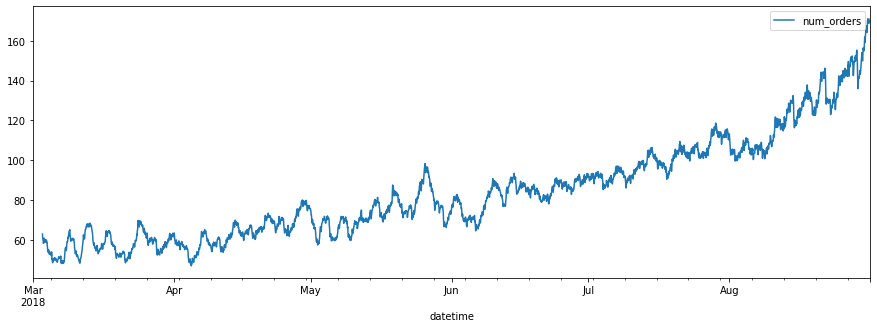

In [12]:
df.rolling(50).mean().plot(figsize=(15, 5))
plt.show()

На графике мы можем наблюдать восходящий тренд.

----

Рассмотрим сезонную составляющую имеющихся данных. 

Так как нам предоставлены данные за один год в период с марта по август, рассматривать будем дневную и еженедельную сезонность.

In [13]:
decomposed_day = seasonal_decompose(df)
decomposed_week = seasonal_decompose(df.resample('1D').sum())

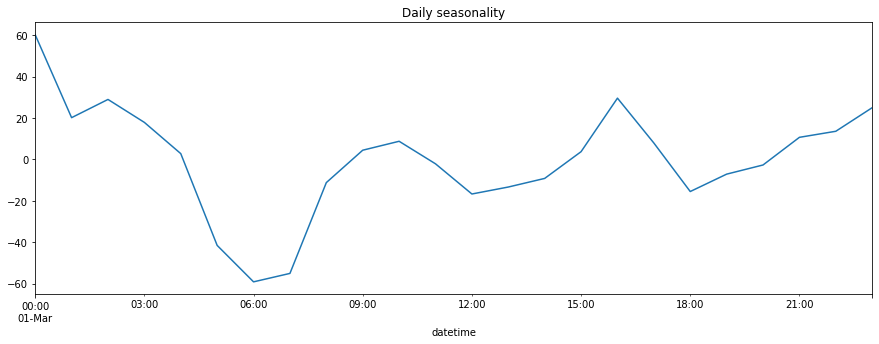

In [14]:
decomposed_day.seasonal['2018-03-01'].plot(figsize=(15, 5), title='Daily seasonality')
plt.show()

Сезонность предоставлена в сутках, так можно наблюдать, что наименьшее количество заказов такси наблюдается в 6 утра.

----

Рассмотрим сезонность в период с понедельника по воскресенье.

<AxesSubplot:title={'center':'Weekly seasonality'}, xlabel='datetime'>

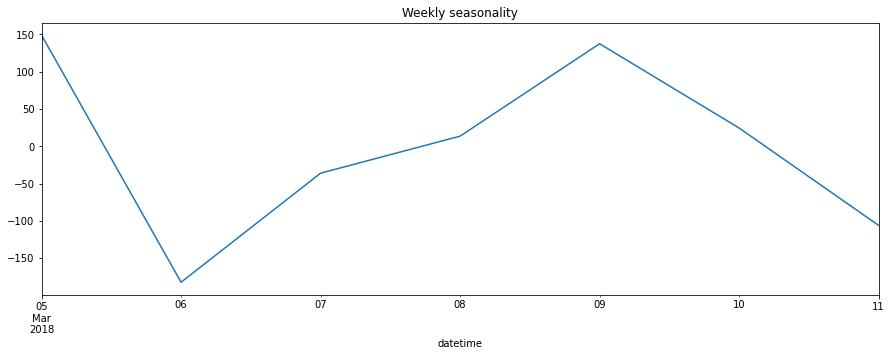

In [15]:
decomposed_week.seasonal['2018-03-05':'2018-03-11'].plot(figsize=(15, 5), title='Weekly seasonality')

На графике можно заметить, что пики заказов приходятся на понедельник и пятницу. Самый ненагруженный день - вторник

## Обучение

Для обучения модели нам потребуется создать признаки.

Напишем функцию для добавления новых признаков в датафрейм.

In [16]:
def new_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Добавим признаки с предыдущими значениями временного ряда.
    for lag in range(1, max_lag + 1):
        data['lag_' + str(lag)] = data['num_orders'].shift(lag)
        
    # Добавим признак со скользящим средним, размер окна которого можно регулировать.    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Разделим данные на тренировочную и тестовую выборки.
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    
    # Очистим обучающие данные от NaN значений.
    train = train.dropna()
    
    # Выделим признаки для обучения модели и целевой признак.
    def features_target_split(sample):
        features = sample.drop(['num_orders'], axis='columns')
        target = sample['num_orders']
        return features, target
    
    train_features, train_target = features_target_split(train)
    test_features, test_target = features_target_split(test)
    
    return train_features, train_target, test_features, test_target

----

Для оценки модели воспользуемся метрикой RMSE.

In [17]:
def rmse(target, predictions):
    return mse(target, predictions, squared=False)

rmse_score = make_scorer(rmse, greater_is_better=False)

### Модель линейной регрессии.

Попробуем подобрать оптимальные параметры для функции, которая добавляет признаки в датафрейм. В качестве экспериментальной модели используем линейную модель.

In [21]:
%%time

model = LinearRegression()

best_rmse = 100
best_max_lag = 0
best_rolling_mean_size = 0

for max_lag in tqdm.tqdm([12, 24, 48, 168]):
    for rol_size in tqdm.tqdm(range(2, 25, 2)):
        train_features, train_target, test_features, test_target = new_features(df, max_lag, rol_size)
        tscv = TimeSeriesSplit(n_splits=3)
        lin_grid = GridSearchCV(model, {}, scoring='neg_root_mean_squared_error', cv=tscv)
        lin_grid.fit(train_features, train_target)
        rmse = lin_grid.best_score_ * -1
        if rmse < best_rmse:
            best_max_lag = max_lag
            best_rolling_mean_size = rol_size
            best_rmse = rmse

print(f'Лучшие параметры для функции определяющей признаки: max_lag = {best_max_lag}, \
      rolling_mean_size = {best_rolling_mean_size}, значение rmse при этом равняется {best_rmse}')
        

# Лучшие параметры для функции определяющей признаки: max_lag = 168, rolling_mean_size = 16, значение rmse при этом равняется 23.043469380130247
# CPU times: user 19.9 s, sys: 23.8 s, total: 43.7 s
# Wall time: 44 s

100%|██████████| 4/4 [00:43<00:00, 11.00s/it]

Лучшие параметры для функции определяющей признаки: max_lag = 168, rolling_mean_size = 16, значение rmse при этом равняется 23.043469380130247
CPU times: user 19.9 s, sys: 23.8 s, total: 43.7 s
Wall time: 44 s


Таким образом наилучшими параметрами для функции определяющий признаки являются: `max_lag=200`, `rolling_mean_size=18`. Сохраним параметры для наших выборок.

In [22]:
train_features, train_target, test_features, test_target = new_features(df, best_max_lag, best_rolling_mean_size)

### Модель случайного леса.

In [23]:
%%time

model = RandomForestRegressor(n_estimators=30, random_state=123)

parametrs = {'max_depth': range(1, 10, 2),
            'n_estimators': range(60, 121, 20)}
            
tscv = TimeSeriesSplit(n_splits=3)
forest_grid = GridSearchCV(model, parametrs, scoring='neg_root_mean_squared_error', cv=tscv)
forest_grid.fit(train_features, train_target)
forest_model_score = forest_grid.best_score_ * -1
print('Качество модели случайного леса:', forest_model_score)
print(forest_grid.best_params_)

# Качество модели случайного леса: 23.728063645562347
# {'max_depth': 9, 'n_estimators': 120}
# CPU times: user 5min 33s, sys: 2.59 s, total: 5min 36s

Качество модели случайного леса: 23.728063645562347
{'max_depth': 9, 'n_estimators': 120}
CPU times: user 5min 33s, sys: 2.59 s, total: 5min 36s
Wall time: 5min 36s


### Модель LGBMRegressor.

In [24]:
%%time

model = lgb.LGBMRegressor(random_state=123)

lgb_parametrs = {"num_leaves": [10, 30, 100]}

tscv = TimeSeriesSplit(n_splits=3)
lgb_grid = GridSearchCV(model, lgb_parametrs, scoring='neg_root_mean_squared_error', cv=tscv)
lgb_grid.fit(train_features, train_target)
lgb_model_score = lgb_grid.best_score_ * -1
print('Качество модели LGBMRegressor:', lgb_model_score)
print(lgb_grid.best_params_)

# Качество модели LGBMRegressor: 23.752076694471153
# {'num_leaves': 10}
# CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s

Качество модели LGBMRegressor: 23.752076694471153
{'num_leaves': 10}
CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 29s


Таким образом наилучшей моделью оказалась модель основанная на алгоритме линейной регрессии, со значением метрики rmse = 23.04, что немного меньше rmse модели случайного леса (rmse = 23.73) и модели линейной регрессии (rmse = 23.75).

## Тестирование

Проверим модель линейной регрессии на тестовой выборке.

In [25]:
lin_grid.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error')

In [26]:
lin_predictions = lin_grid.predict(test_features)

In [31]:
mse(test_target, lin_predictions) ** 0.5

34.79155157267944

Таким образом, значение rmse линейной модели на тестовой выборке составило 34.79.

----

Сравним на графике предсказанные значения с истинными.

In [80]:
predictions = pd.Series(lin_predictions, index=test_target.index)

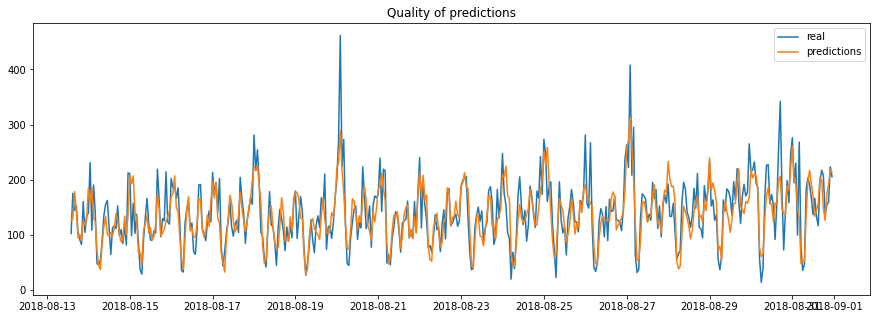

In [85]:
plt.figure(figsize=(15, 5))
plt.plot(test_target, label='real')
plt.plot(predictions, label='predictions')
plt.legend()
plt.title('Quality of predictions')

plt.show()


## Вывод

Задачей исследования являлось построение модели для компании «Чётенькое такси» для прогноза количества заказов такси на следующий час.

Нам были предоставленны данные о заказах такси в аэропортах в 10 минутных интервалах в период с марта по август 2018 года. Было проведено ресемплирование и анализ данных. 

В предоставленный период наблюдался восходящий тренд заказов такси. В суточной сезонности наименьшее количество заказов такси наблюдается в 6 утра. В недельной сезонности можно наблюдать, что пики заказов приходятся на понедельник и пятницу. Самый ненагруженный день - вторник.

Для обучения моделей были созданы календарные признаки, отстающие (lag) значения, скользящее среднее.

Было рассмотрено три модели: модель линейной регрессии, модель случайного леса и модель градиентного бустинга. Наилучший результат показала модель линейной регрессии со значением метрики RMSE на тестовой выборке равным 34.79.